# GSM predictions vs 13C-MFA measurement scatterplots

### Import dependencies

In [1]:
import pandas as pd
import sys

source_dir = '../src'
sys.path.append(source_dir)
from plot import *

output_dir = '../plots/'

### Load flux prediction data

In [2]:
# load WT glucose data
glucose_fba_pfba_fluxes = pd.read_csv('../data/central_fluxes/glucose_FBA_pFBA.csv')
glucose_eflux2_fluxes = pd.read_csv('../data/central_fluxes/glucose_EFlux2.csv')
glucose_spot_fluxes = pd.read_csv('../data/central_fluxes/glucose_SPOT.csv')

# load WT phenol data
phenol_wt_fba_pfba_fluxes = pd.read_csv('../data/central_fluxes/phenol_FBA_pFBA.csv')
phenol_wt_eflux2_fluxes = pd.read_csv('../data/central_fluxes/phenol_EFlux2_WT.csv')
phenol_wt_spot_fluxes = pd.read_csv('../data/central_fluxes/phenol_SPOT_WT.csv')

# load PVHG6 phenol data
phenol_pvhg6_fba_pfba_fluxes = pd.read_csv('../data/central_fluxes/phenol_FBA_pFBA.csv')
phenol_pvhg6_eflux2_fluxes = pd.read_csv('../data/central_fluxes/phenol_EFlux2_PVHG6.csv')
phenol_pvhg6_spot_fluxes = pd.read_csv('../data/central_fluxes/phenol_SPOT_PVHG6.csv')

### Define a function to plot pFBA, E-Flux2, and SPOT flux predictions

In [8]:
def plot_flux_comparisons(fluxes_dfs, strain, axis_bounds):
    # Create the subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 18))

    locations = [
        (0, 0), 
        (0, 1),
        (1, 0)
    ]

    methods = ['pFBA', 'E-Flux2', 'SPOT']

    for location, method, fluxes_df in zip(locations, methods, fluxes_dfs):
        # 
        if location == (0, 0):
            strain_name = 'WT'
        else: 
            strain_name = strain
        
        # define column names
        prediction_column_name = f'{method} {strain_name} Flux'
        prediction_std_column_name = f'{method} {strain_name} Flux Std'

        # create a list of pathways from the dataframe, this is sorted so the colors match on all plots
        pathway_list = sorted(list(set(fluxes_df['Pathway'])))
        pathway_list.remove('Biomass Equation') # don't plot this point
        # pathway_list.remove('ATPM') # don't plot this point

        # make lists of the measured fluxes and the predicted fluxes for statistic calculations
        unfiltered_measurements =  fluxes_df.loc[:, '13C Flux']
        unfiltered_predictions = fluxes_df.loc[:, prediction_column_name]

        # make list with outliers filtered out
        filtered_measurements =  fluxes_df.loc[~fluxes_df['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH']), '13C Flux']
        filtered_predictions = fluxes_df.loc[~fluxes_df['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH']), prediction_column_name]

        # calculate r2 value for unfiltered data
        _, _, unfiltered_r, _, _ = linregress(unfiltered_measurements, unfiltered_predictions)
        unfiltered_r2 = unfiltered_r * unfiltered_r

        # calculate r2 value for filtered data
        _, _, filtered_r, _, _ = linregress(filtered_measurements, filtered_predictions)
        filtered_r2 = filtered_r * filtered_r

        # loop over each pathway
        for pathway in pathway_list:
            # make a pathway specific filtered dataframe
            pathway_df = fluxes_df[fluxes_df['Pathway'] == pathway]

            # don't plot ATP maintenance
            # if pathway == 'Energy Reactions':
            #     pathway_df = pathway_df[pathway_df['Reaction Ids'] != 'ATPM']

            # make lists of measured and predicted fluxes
            measured_flux_list = list(pathway_df['13C Flux'])
            predicted_flux_list = list(pathway_df[prediction_column_name])

            # add the points for each pathway to the plot
            sc = axs[location].scatter(measured_flux_list, predicted_flux_list, label=pathway)

            # this is incorrect (update later with custom upper and lower bound errors)
            # calculate horizontal error bars
            measured_std_list = list(pathway_df['13C Upper Bound']-pathway_df['13C Flux'])

            # if prediction standard deviations are included, then add vertical and horizontal error bars
            if prediction_std_column_name in pathway_df.columns:
                # make a list of predicted flux standard deviations
                predicted_std_list = list(pathway_df[prediction_std_column_name])

                axs[location].errorbar(
                    measured_flux_list, 
                    predicted_flux_list, 
                    xerr=[std1 for std1 in measured_std_list], 
                    yerr=[1.9*std for std in predicted_std_list], 
                    ecolor="gray", 
                    ls='none', 
                    alpha=0.8
                )

            # if prediction standard deviations are NOT included, then only add horizontal error bars
            else: 
                axs[location].errorbar(
                    measured_flux_list, 
                    predicted_flux_list, 
                    xerr=[std1 for std1 in measured_std_list], 
                    ecolor="gray", 
                    ls='none', 
                    alpha=0.8
                )

        # add 45 degree dashed line
        # x = np.linspace(*axs[location].get_xlim())
        # axs[location].plot(x, x, ls="--", c=".3")
        dotted_line = np.linspace(*axis_bounds)
        axs[location].plot(dotted_line, dotted_line, ls="--", c=".3")

        # axs[location].plot(x, y1, label='sin(x)')

        # set title and axes labels
        title = r''+ r"$\bf{" + str(method) + "}$"  + ': ' + f"$R^2$={filtered_r2:.2F} ({unfiltered_r2:.2F}$^\star$)"
        axs[location].set_title(title, fontsize=24)
        axs[location].set_ylabel(f'Predicted Flux', fontsize=22)
        axs[location].set_xlabel(f'13C-MFA Flux', fontsize=22)

        # add styles to the plot
        axs[location].tick_params(axis='both', labelsize=14)

        axs[location].set_xlim(axis_bounds)
        axs[location].set_ylim(axis_bounds)


    # Add legend to axs[0, 0]
    handles, labels = axs[0, 0].get_legend_handles_labels()

    # Add the legend to axs[1, 1] location
    legend = axs[1, 1].legend(handles, labels, fontsize=18, loc='center', markerscale=1.5)
    # Add title to the legend
    fig.text(0.715, 0.41, 'Pathway Labels:', ha='center', fontsize=22)

    # Hide everything except the legend in axs[1, 1]
    axs[1, 1].spines['top'].set_visible(False)
    axs[1, 1].spines['right'].set_visible(False)
    axs[1, 1].spines['bottom'].set_visible(False)
    axs[1, 1].spines['left'].set_visible(False)
    axs[1, 1].tick_params(axis='both', which='both', length=0)
    axs[1, 1].set_xticklabels([])
    axs[1, 1].set_yticklabels([])

    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.22, wspace=0.22)

    # Show the plot
    plt.show()

### Plot WT phenol data

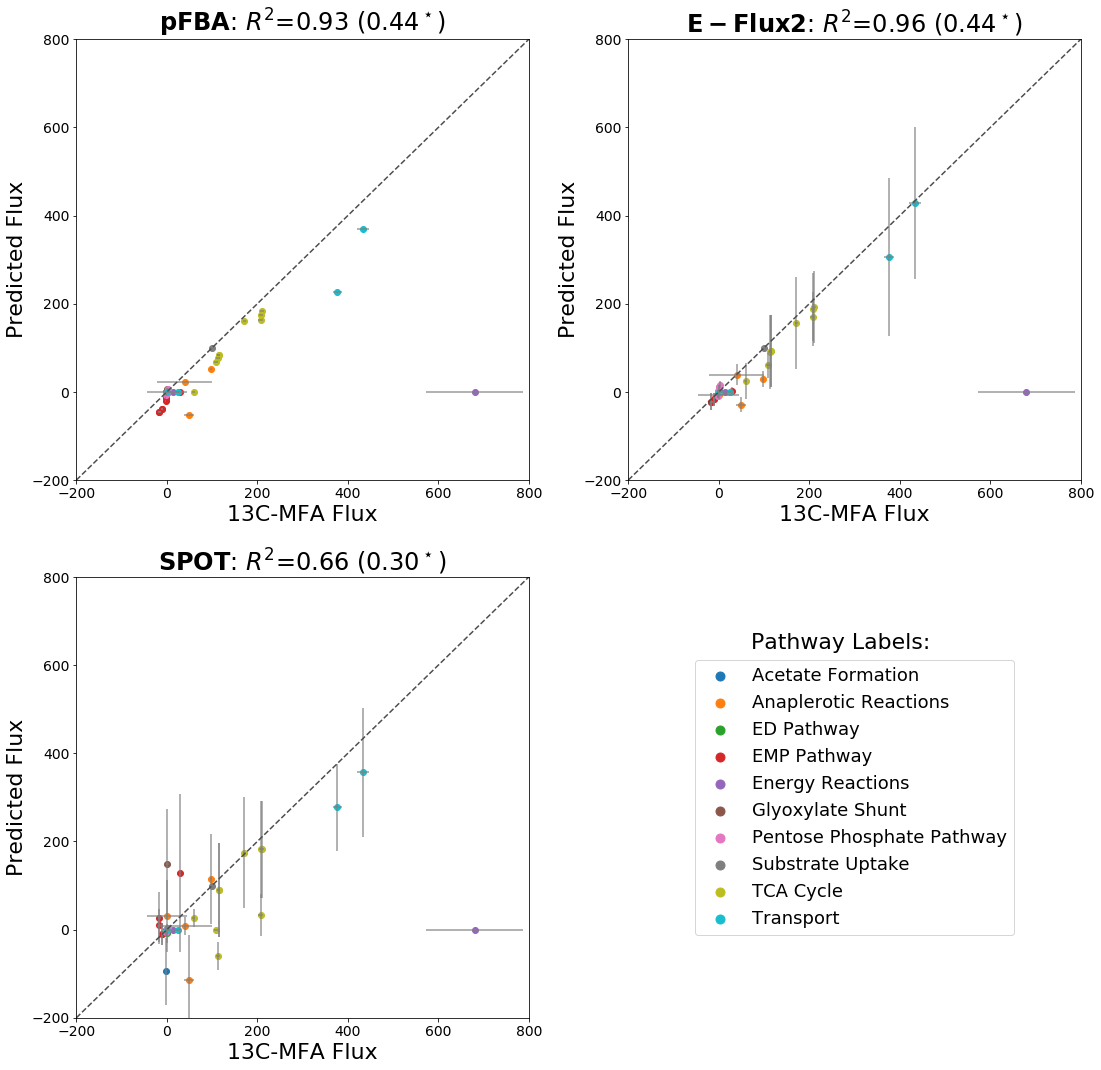

In [12]:
# define varibles 
fluxes_dfs = [
    phenol_wt_fba_pfba_fluxes,
    phenol_wt_eflux2_fluxes,
    phenol_wt_spot_fluxes
]
strain = 'WT'
axis_bounds = [-200, 800]

# run function
plot_flux_comparisons(fluxes_dfs, strain, axis_bounds)

### Plot WT glucose data

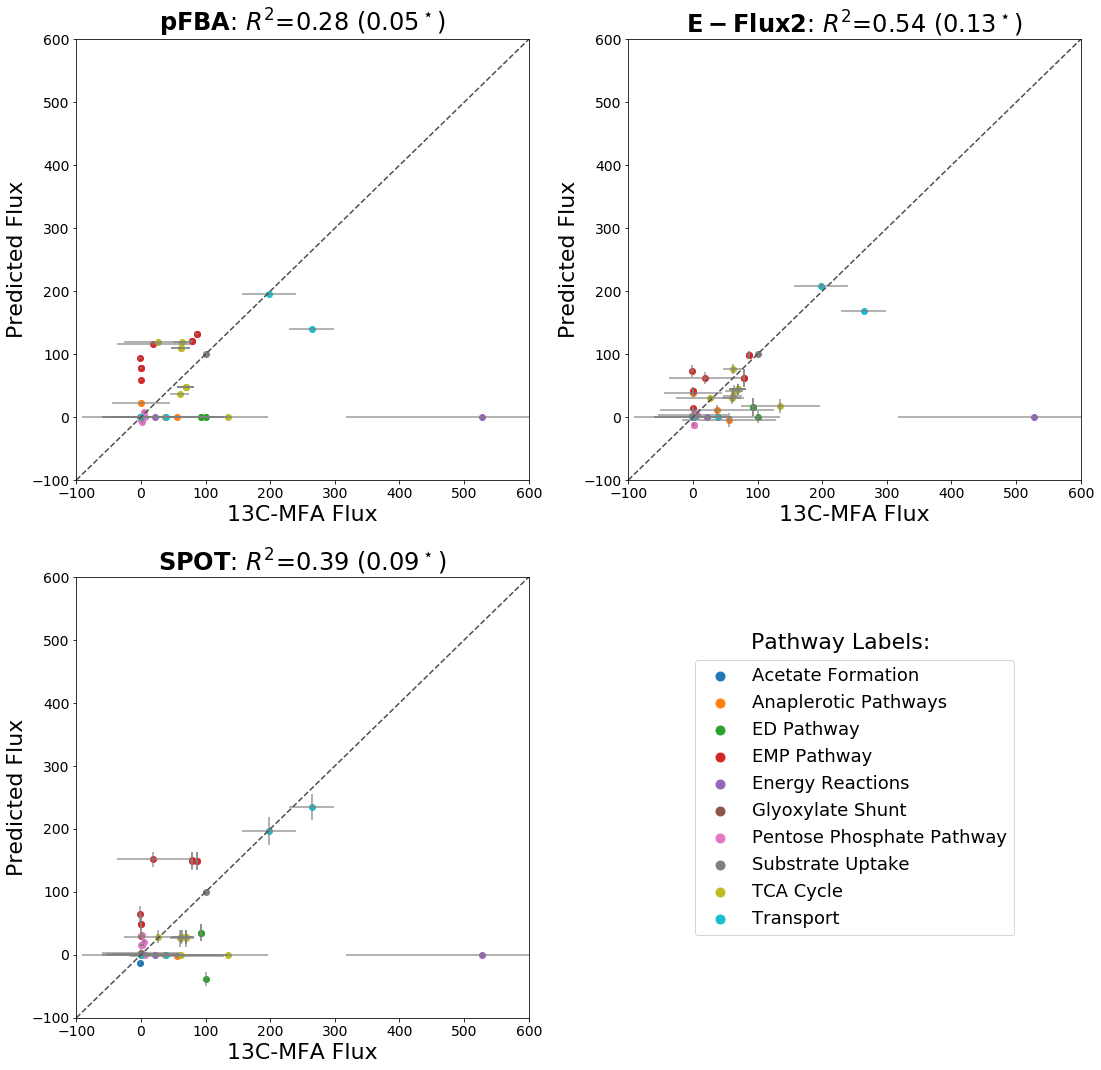

In [13]:
# define varibles 
fluxes_dfs = [
    glucose_fba_pfba_fluxes,
    glucose_eflux2_fluxes,
    glucose_spot_fluxes
]
strain = 'WT'
axis_bounds = [-100, 600]

# run function
plot_flux_comparisons(fluxes_dfs, strain, axis_bounds)

### Plot PVHG6 phenol data

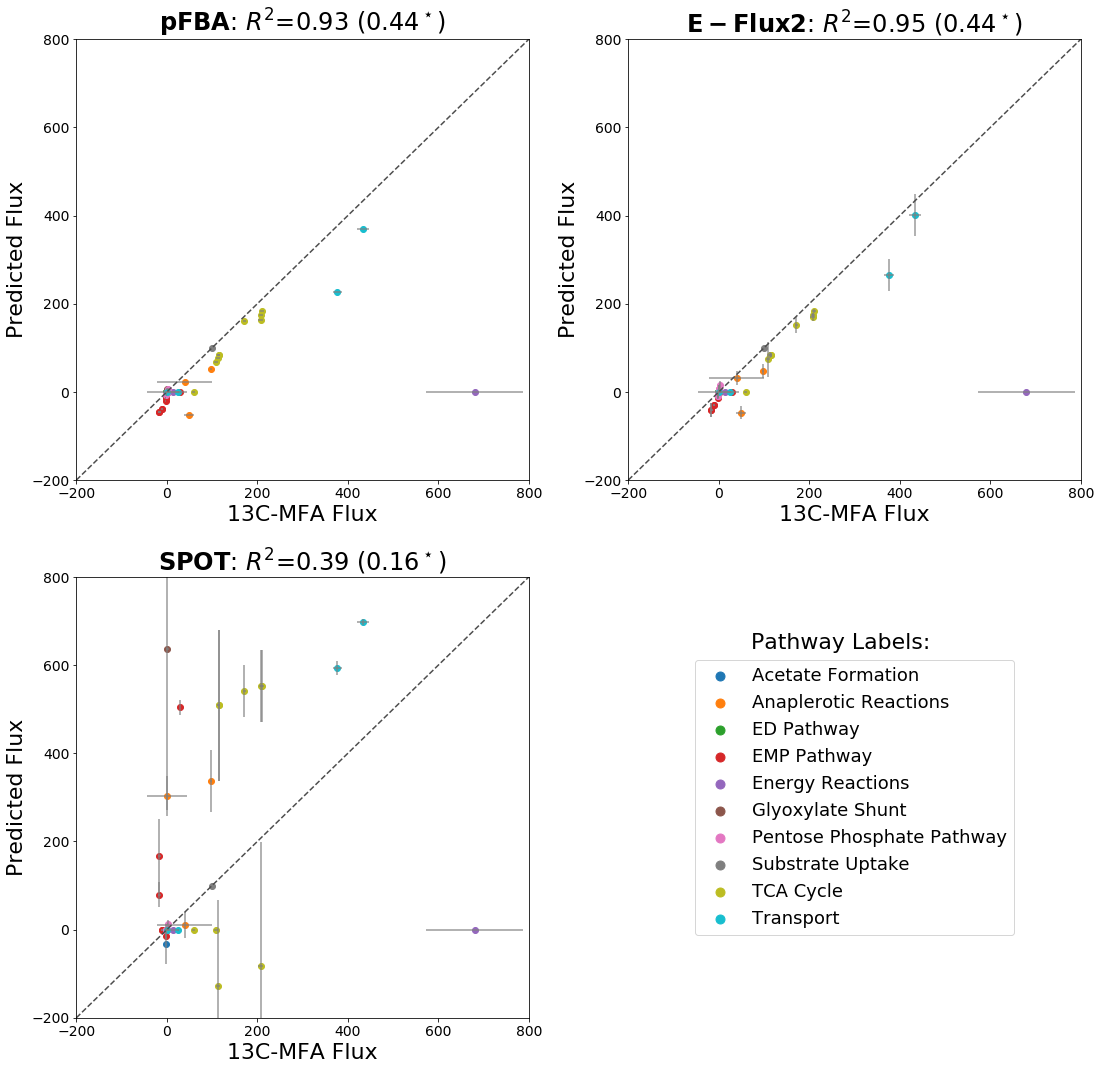

In [11]:
# define varibles 
fluxes_dfs = [
    phenol_pvhg6_fba_pfba_fluxes,
    phenol_pvhg6_eflux2_fluxes,
    phenol_pvhg6_spot_fluxes
]
strain = 'PVHG6'
axis_bounds = [-200, 800]

# run function
plot_flux_comparisons(fluxes_dfs, strain, axis_bounds)